### Autoencoder model on CTG dataset
- Load Data
- Preprocess Data
- Perform PCA on Data
- Define Autoencoder Model
- Train Model
- Generate predictions for Train and Test Sets
- Perform PCA on Encoded Data
- Evaluate Latent Spaces for AE and PCA with clustering and silhouette score
- Evaluate generated data on classification models

In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
ctg_data = pd.read_csv('../CTGRawData.csv', sep=';')

In [2]:
# Preprocess Data
# Separate Features from labels (last column)
y = ctg_data['NSP']
X = ctg_data.drop('NSP',axis=1).iloc[:,:21]
from sklearn.model_selection import train_test_split
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [3]:
# Normalization of data sets
# Data Scaling MinMax
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_norm = X_train
X_test_norm = X_test

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train_norm))
X_test_norm = pd.DataFrame(scaler.transform(X_test_norm))


In [4]:
# Check Shape of data
print(X_train_norm.head())
print(X_train_norm.shape)
print(np.array(X_train_norm)[:5])
# 21 features that we are going to try to reduce.

         0         1         2         3         4         5    6         7   \
0  0.240741  0.038462  0.000000  0.260870  0.189189  0.147059  0.0  0.272189   
1  0.444444  1.000000  0.005319  0.565217  0.527027  0.205882  0.0  0.082840   
2  0.518519  0.000000  0.000000  0.000000  0.932432  0.000000  1.0  0.025641   
3  0.351852  0.000000  0.000000  0.217391  0.716216  0.161765  0.0  0.059172   
4  0.703704  0.269231  0.012411  0.130435  0.297297  0.205882  0.0  0.390533   

       8    9   ...        11        12        13        14     15        16  \
0  0.0000  0.0  ...  0.208092  0.513761  0.198276  0.055556  0.000  0.472441   
1  0.7500  0.0  ...  0.612717  0.247706  0.551724  0.222222  0.000  0.661417   
2  0.0000  0.0  ...  0.000000  0.761468  0.120690  0.055556  0.000  0.590551   
3  0.3125  0.0  ...  0.427746  0.256881  0.284483  0.222222  0.000  0.393701   
4  0.0000  0.0  ...  0.583815  0.192661  0.456897  0.222222  0.125  0.692913   

         17        18        19   20  

_____________________________
### PCA

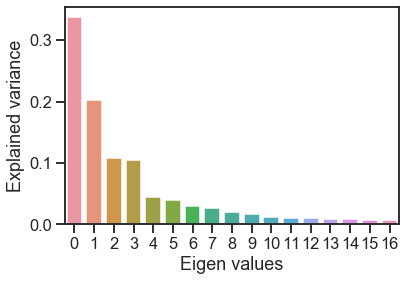

0.8366899883429842

In [31]:
# Perform PCA to find the most significant features
from sklearn.decomposition import PCA
# select the number of components
pca = PCA(n_components = 17)
X_train_pca = pca.fit_transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

x_pca_train_labeled = np.c_[X_train_pca , y_train]
x_pca_test_labeled = np.c_[X_test_pca , y_test]

sns.barplot(np.arange(np.shape(pca.explained_variance_ratio_)[0]),pca.explained_variance_ratio_)
plt.xlabel("Eigen values")
plt.ylabel("Explained variance")
plt.show()

pca.explained_variance_ratio_[:6].sum()

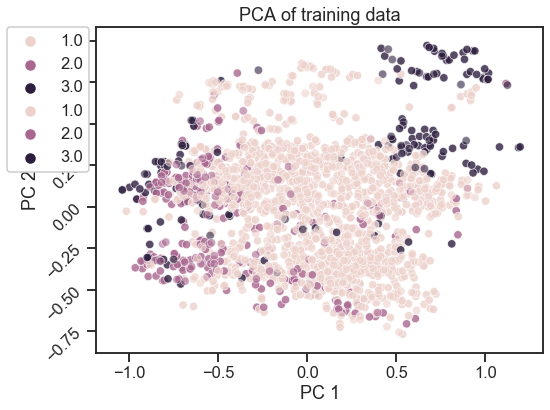

In [55]:
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
ax1 = plt.subplot()
sns.scatterplot(x=x_pca_train_labeled[:,0], 
                y=x_pca_train_labeled[:,1], 
                alpha = 0.8, 
                s= 70, legend='full', 
                hue=x_pca_train_labeled[:,-1])
sns.scatterplot(x=x_pca_test_labeled[:,0],
                y=x_pca_test_labeled[:,1],
                alpha = 0.6, 
                s= 70, 
                legend='full',
                hue=x_pca_test_labeled[:,-1])
ax1.legend(bbox_to_anchor=(-0.2, 1), loc=2, borderaxespad=0.,framealpha=1, frameon=True)
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (8,6) )
ax1.set_title("PCA of training data")
plt.yticks(rotation=45) 
plt.show()

In [34]:
# Keep the first 6 components that sum to >80% of variation
X_pca = X_train_pca[:,:6]
X_pca_test = X_test_pca[:,:6]

__________________________
### Kernel PCA

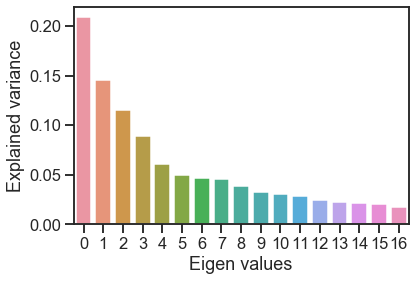

0.670691117252682

In [156]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=17, kernel="rbf", fit_inverse_transform=True, gamma=2)
X_kpca = kpca.fit_transform(X_train_norm)
X_kpca_test = kpca.transform(X_test_norm)

X_kpca_var = np.var(X_kpca,0)
X_kpca_var_ratio = X_kpca_var / sum(X_kpca_var)

X_kpca_train_labeled = np.c_[X_kpca , y_train]

sns.barplot(np.arange(np.shape(X_kpca_var_ratio)[0]),X_kpca_var_ratio)
plt.xlabel("Eigen values")
plt.ylabel("Explained variance")
plt.show()

X_kpca_var_ratio[:6].sum()


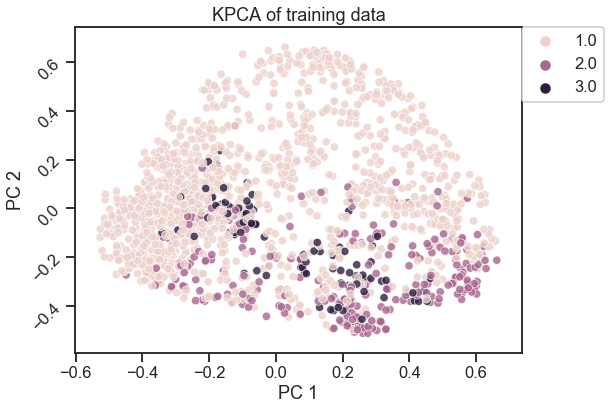

In [157]:
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
ax1 = plt.subplot()
sns.scatterplot(x=X_kpca[:,0], 
                y=X_kpca[:,1], 
                alpha = 0.8, 
                s= 70, legend='full', 
                hue=X_kpca_train_labeled[:,-1])
ax1.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,framealpha=1, frameon=True)
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (8,6) )
ax1.set_title("KPCA of training data")
plt.yticks(rotation=45) 
plt.show()

In [158]:
# Keep the first 6 components, this is to match the 6 dimensions of the PCA reduced data, as it has >80% of variance. In kPCA its < 80%.
# We should try adding dimensions to all models to have > 80% on PCA and kPCA.
X_kpca = X_kpca[:,:6]
X_kpca_test = X_test_pca[:,:6]

__________________________________________
### Autoencoder

In [7]:
## Definition of Auxiliar functions: loss function, gradient function and model training function
from typing import List

def loss(x: np.ndarray, x_bar: np.ndarray) -> float:
    return tf.losses.mean_squared_error(x, x_bar)

def grad(model: keras.models.Model, inputs: np.ndarray):
    with tf.GradientTape() as tape:
        reconstruction, inputs_reshaped = model(inputs)
        loss_value = loss(inputs_reshaped, reconstruction)
    return loss_value, tape.gradient(loss_value, model.trainable_variables), inputs_reshaped, reconstruction

def train_model(model: keras.models.Model, inputs: pd.DataFrame, num_epochs: int, batch_size: int):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    x_train = np.array(inputs)

    for epoch in range(num_epochs):
        for x in range(0, len(x_train), batch_size):
            x_inp = x_train[x : x + batch_size]
            loss_value, grads, inputs_reshaped, reconstruction = grad(model, x_inp)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        print("Step: {},Loss: {}".format(epoch, sum(loss(inputs_reshaped, reconstruction)/batch_size).numpy()))

In [ ]:
# Define Autoencoder
class ComposeAutoEncoder(keras.models.Model):
    def __init__(self):
        super(ComposeAutoEncoder, self).__init__()
        
        # this is the size of our encoded representations
        encoding_dim = 16  # 21/16 - we will try to reduce the dimensions to this number.
        # this is our input placeholder
        input_features = layers.Input(shape=(21))

        self.flatten_input = layers.Flatten()(input_features)
        # "Encoder layers"
        self.encoder1 = layers.Dense(64, activation='relu')(self.flatten_input)
        self.encoder2 = layers.Dense(32, activation='relu')(self.encoder1)
        # "Encoder output" - "bottleneck"
        self.bottleneck = layers.Dense(encoding_dim, activation='relu')(self.encoder2)
        # this model maps an input to its encoded representation
        self.encoder = keras.models.Model(input_features, self.bottleneck, name='encoder')

        # "Decoder layers"
        # create a placeholder for an encoded (32-dimensional) input
        self.encoded_input = layers.Input(shape=(encoding_dim,))
        self.decoder1 = layers.Dense(32, activation='relu')(self.encoded_input)
        self.decoder2 = layers.Dense(64, activation='relu')(self.decoder1)
        # "decoded" is the lossy reconstruction of the input
        self.decoded = layers.Dense(21, activation='sigmoid')(self.decoder1)
        # create the decoder model
        self.decoder = keras.models.Model(self.encoded_input, self.decoded, name='decoder')

    
    def call(self, inp):
        # full autoencoder for training
        encoder_model = self.encoder(inp)
        decoder_model = self.decoder(encoder_model)

        return decoder_model, inp

In [ ]:
# Instantiate and train model
autoencoder = ComposeAutoEncoder()
train_model(autoencoder, X_train_norm, num_epochs=100, batch_size=400)

In [8]:
# Define Simple Autoencoder One-layered encoder and decoder
class SimpleAutoEncoder(keras.models.Model):
    def __init__(self):
        super(SimpleAutoEncoder, self).__init__()
        
        # this is the size of our encoded representations
        encoding_dim = 5  # 21/5 - we will try to reduce the dimensions to this number.
        # this is our input placeholder
        input_features = layers.Input(shape=(21))

        self.flatten_input = layers.Flatten()(input_features)
        # "Encoder layers"
        self.encoder1 = layers.Dense(16, activation='relu')(self.flatten_input)
        # "Encoder output" - "bottleneck"
        self.bottleneck = layers.Dense(encoding_dim, activation='relu')(self.encoder1)
        
        # this model maps an input to its encoded representation
        self.encoder = keras.models.Model(input_features, self.bottleneck, name='encoder')

        # "Decoder layers"
        # create a placeholder for an encoded input
        self.encoded_input = layers.Input(shape=(encoding_dim,))
        self.decoder1 = layers.Dense(16, activation='relu')(self.encoded_input)
        # "decoded" is the lossy reconstruction of the input
        self.decoded = layers.Dense(21, activation='sigmoid')(self.decoder1)
        # create the decoder model
        self.decoder = keras.models.Model(self.encoded_input, self.decoded, name='decoder')

    
    def call(self, inp):
        # full autoencoder for training
        encoder_model = self.encoder(inp)
        decoder_model = self.decoder(encoder_model)

        return decoder_model, inp

In [18]:
# Define Complex Autoencoder Two-layered encoder and decoder
class ComplexAutoEncoder(keras.models.Model):
    def __init__(self):
        super(ComplexAutoEncoder, self).__init__()
        
        # this is the size of our encoded representations
        encoding_dim = 5  # 21/5 - we will try to reduce the dimensions to this number.
        # this is our input placeholder
        input_features = layers.Input(shape=(21))

        self.flatten_input = layers.Flatten()(input_features)
        # "Encoder layers"
        self.encoder1 = layers.Dense(16, activation='relu')(self.flatten_input)
        self.batch_norm1 = layers.BatchNormalization()(self.encoder1)
        self.encoder2 = layers.Dense(12, activation='relu')(self.batch_norm1)
        # "Encoder output" - "bottleneck"
        self.bottleneck = layers.Dense(encoding_dim, activation='relu')(self.encoder2)
        
        # this model maps an input to its encoded representation
        self.encoder = keras.models.Model(input_features, self.bottleneck, name='encoder')

        # "Decoder layers"
        # create a placeholder for an encoded input
        self.encoded_input = layers.Input(shape=(encoding_dim,))
        self.decoder1 = layers.Dense(12, activation='relu')(self.encoded_input)
        self.batch_norm2 = layers.BatchNormalization()(self.decoder1)
        self.decoder2 = layers.Dense(16, activation='relu')(self.batch_norm2)
        self.batch_norm3 = layers.BatchNormalization()(self.decoder2)
        # "decoded" is the lossy reconstruction of the input
        self.decoded = layers.Dense(21, activation='sigmoid')(self.batch_norm3)
        # create the decoder model
        self.decoder = keras.models.Model(self.encoded_input, self.decoded, name='decoder')

    
    def call(self, inp):
        # full autoencoder for training
        encoder_model = self.encoder(inp)
        decoder_model = self.decoder(encoder_model)

        return decoder_model, inp

In [19]:
# Train Autoencoders
simple_autoencoder = SimpleAutoEncoder()
train_model(simple_autoencoder, X_train_norm, num_epochs=100, batch_size=400)
complex_autoencoder = ComplexAutoEncoder()
train_model(complex_autoencoder, X_train_norm, num_epochs=100, batch_size=400)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Step: 0,Loss: 0.03261960670351982
Step: 1,Loss: 0.032242655754089355
Step: 2,Loss: 0.031936027109622955
Step: 3,Loss: 0.03165406361222267
Step: 4,Loss: 0.031373582780361176
Step: 5,Loss: 0.031071098521351814
Step: 6,Loss: 0.030725745484232903
Step: 7,Loss: 0.030321653932332993
Step: 8,Loss: 0.029846100136637688
Step: 9,Loss: 0.029288413003087044
Step: 10,Loss: 0.028637997806072235
Step: 11,Loss: 0.027886122465133667
Step: 12,Loss: 0.027026960626244545
Step: 13,Loss: 0.02605924755334854
Step: 14,Loss: 0.

In [20]:
simple_predictions = simple_autoencoder.predict(np.array(X_test_norm))
complex_predictions = complex_autoencoder.predict(np.array(X_test_norm))

In [21]:
# Analyze values of a few features
simple_predictions_dataframe = pd.DataFrame(simple_predictions[0])
complex_predictions_dataframe = pd.DataFrame(complex_predictions[0])
original_dataframe = pd.DataFrame(simple_predictions[1])
print(simple_predictions_dataframe.iloc[:,:5].describe())
print(complex_predictions_dataframe.iloc[:,:5].describe())
print(original_dataframe.iloc[:,:5].describe())

                0           1           2           3           4
count  426.000000  426.000000  426.000000  426.000000  426.000000
mean     0.505855    0.104604    0.014786    0.151837    0.488215
std      0.108175    0.042958    0.008963    0.050904    0.143331
min      0.201420    0.035461    0.003739    0.075098    0.197784
25%      0.437706    0.070673    0.008432    0.115359    0.381020
50%      0.504384    0.099127    0.012573    0.141464    0.503397
75%      0.586007    0.136334    0.018859    0.173653    0.575573
max      0.740192    0.216507    0.076341    0.380962    0.796403
                0           1           2           3           4
count  426.000000  426.000000  426.000000  426.000000  426.000000
mean     0.513025    0.101932    0.016077    0.155400    0.474158
std      0.074971    0.040364    0.022068    0.028560    0.108917
min      0.340594    0.021364    0.001129    0.091037    0.326746
25%      0.461163    0.072167    0.004929    0.133190    0.382740
50%      0

In [22]:
## Encode Train and Test Data
simple_encoded_train = simple_autoencoder.encoder.predict(X_train_norm)
simple_encoded_test = simple_autoencoder.encoder.predict(X_test_norm)
complex_encoded_train = complex_autoencoder.encoder.predict(X_train_norm)
complex_encoded_test = complex_autoencoder.encoder.predict(X_test_norm)
# Renormalize input
scaler = MinMaxScaler()
simple_encoded_train = pd.DataFrame(scaler.fit_transform(simple_encoded_train))
simple_encoded_test = pd.DataFrame(scaler.transform(simple_encoded_test))
complex_encoded_train = pd.DataFrame(scaler.fit_transform(complex_encoded_train))
complex_encoded_test = pd.DataFrame(scaler.transform(complex_encoded_test))

______________________________________
### PCA on encoded data

In [23]:
pca = PCA(n_components=4)
simple_encoded_pca_train = pca.fit_transform(simple_encoded_train)
simple_encoded_pca_test = pca.transform(simple_encoded_test)

c_pca = PCA(n_components=4)
complex_encoded_pca_train = c_pca.fit_transform(complex_encoded_train)
complex_encoded_pca_test = c_pca.transform(complex_encoded_test)

simple_encoded_pca_train_labeled = np.c_[simple_encoded_pca_train , y_train]
simple_encoded_pca_test_labeled = np.c_[simple_encoded_pca_test , y_test]
complex_encoded_pca_train_labeled = np.c_[complex_encoded_pca_train , y_train]
complex_encoded_pca_test_labeled = np.c_[complex_encoded_pca_test , y_test]

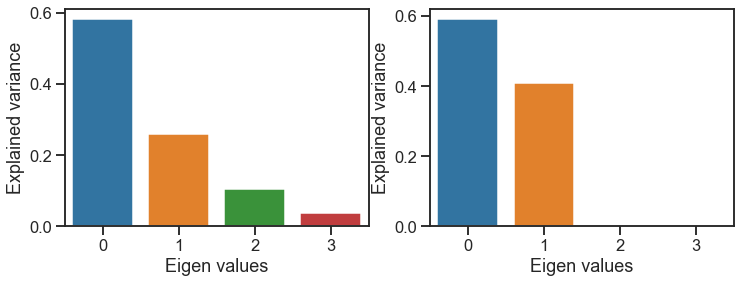

Simple PCA explained variance ratio: 0.9825129100313525
Complex PCA explained variance ratio: 1.0


In [24]:
plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1,2,1)
sns.barplot(np.arange(np.shape(pca.explained_variance_ratio_)[0]),pca.explained_variance_ratio_)
plt.xlabel("Eigen values")
plt.ylabel("Explained variance")

ax1 = plt.subplot(1,2,2)
sns.barplot(np.arange(np.shape(c_pca.explained_variance_ratio_)[0]),c_pca.explained_variance_ratio_)
plt.xlabel("Eigen values")
plt.ylabel("Explained variance")
plt.show()

print(f"Simple PCA explained variance ratio: {pca.explained_variance_ratio_.sum()}")
print(f"Complex PCA explained variance ratio: {c_pca.explained_variance_ratio_.sum()}")

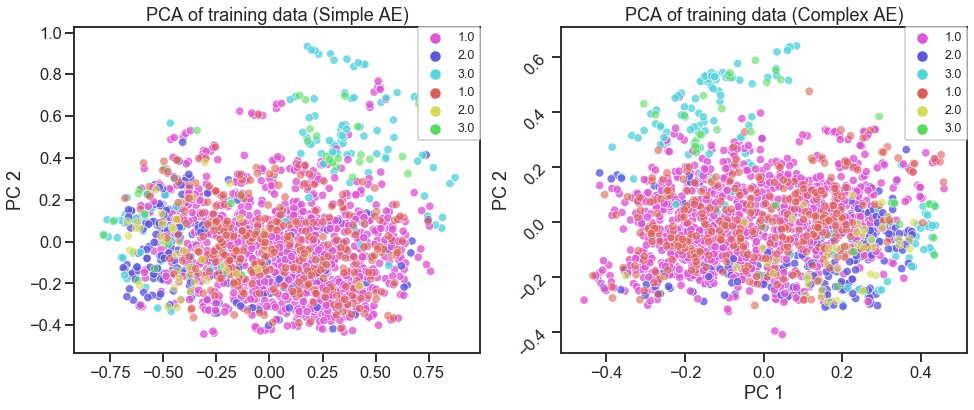

In [25]:
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
ax1 = plt.subplot(1,2,1)
sns.scatterplot(x=simple_encoded_pca_train_labeled[:,0], 
                y=simple_encoded_pca_train_labeled[:,1], 
                alpha = 0.8, 
                s= 70, legend='full', 
                hue=simple_encoded_pca_train_labeled[:,-1],
                palette=sns.color_palette("hls")[:2:-1])
sns.scatterplot(x=simple_encoded_pca_test_labeled[:,0],
                y=simple_encoded_pca_test_labeled[:,1],
                alpha = 0.6, 
                s= 70, 
                legend='full',
                hue=simple_encoded_pca_test_labeled[:,-1], 
                palette=sns.color_palette("hls")[:3])
ax1.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.,framealpha=1, frameon=True, fontsize="x-small")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (16,6) )
ax1.set_title("PCA of training data (Simple AE)")

ax1 = plt.subplot(1,2,2)
sns.scatterplot(x=complex_encoded_pca_train_labeled[:,0], 
                y=complex_encoded_pca_train_labeled[:,1], 
                alpha = 0.8, 
                s= 70, legend='full', 
                hue=complex_encoded_pca_train_labeled[:,-1],
                palette=sns.color_palette("hls")[:2:-1])
sns.scatterplot(x=complex_encoded_pca_test_labeled[:,0],
                y=complex_encoded_pca_test_labeled[:,1],
                alpha = 0.6, 
                s= 70, 
                legend='full',
                hue=complex_encoded_pca_test_labeled[:,-1], 
                palette=sns.color_palette("hls")[:3])
ax1.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.,framealpha=1, frameon=True, fontsize="x-small")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (16,6) )
ax1.set_title("PCA of training data (Complex AE)")

plt.yticks(rotation=45) 
plt.show()

______________________
### DNN Classifier

In [26]:
# One hot encode labels
from sklearn.preprocessing import LabelEncoder
OH_encoder = LabelEncoder()
OH_y_train = pd.DataFrame(OH_encoder.fit_transform(y_train))
OH_y_test = pd.DataFrame(OH_encoder.transform(y_test))
y_train_oh = keras.utils.to_categorical(OH_y_train)
y_test_oh = keras.utils.to_categorical(OH_y_test)

In [27]:
## Test the encoded input on the best classifier obtained previously (CTG_dataset_classification)
def build_best_model(penalization: int, input_shape):
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization), input_shape=(input_shape,)),
    layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(64,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(3,activation=tf.nn.softmax)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

In [163]:
# Fit best model with original dimension data
best_model = build_best_model(0.00001, len(X_train_norm.keys()))
history = best_model.fit(X_train_norm, y_train_oh, epochs=86,
                    validation_split = 0, verbose=0, callbacks=[])
hist = pd.DataFrame(history.history)

test_loss, test_acc = best_model.evaluate(X_test_norm, y_test_oh)

# Fit best model with reduced dimension data
encoded_model = build_best_model(0.00001, len(complex_encoded_train.keys()))
history_encoded = encoded_model.fit(complex_encoded_train, y_train_oh, epochs=86,
                    validation_split = 0, verbose=0, callbacks=[])
hist_encoded = pd.DataFrame(history_encoded.history)

test_loss, test_acc = encoded_model.evaluate(complex_encoded_test, y_test_oh)

# Fit best model with KPCA reduced dimension data
encoded_model = build_best_model(0.00001, X_kpca.shape[1])
history_encoded = encoded_model.fit(X_kpca, y_train_oh, epochs=86,
                    validation_split = 0, verbose=0, callbacks=[])
hist_encoded = pd.DataFrame(history_encoded.history)

test_loss, test_acc = encoded_model.evaluate(X_kpca_test, y_test_oh)


426/426 [==============================] - 0s 171us/sample - loss: 0.3627 - accuracy: 0.8756
426/1 [====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [30]:
## Keep the encoded datasets for latent space evaluation
X_encoded_simple = simple_encoded_train
X_encoded_test_simple = simple_encoded_test
X_encoded_complex = complex_encoded_train
X_encoded_test_complex = simple_encoded_test

### Differences:
##### 1- original data=0.9272 ; reduced data= 0.8545
##### 2- original data=0.9178 ; reduced data= 0.8568
##### 3- original data=0.9249 ; reduced data= 0.8545

______________________
### 2-dimensional AE

In [37]:
# Define Simple Autoencoder One-layered encoder and decoder
class TwoDimAutoEncoder(keras.models.Model):
    def __init__(self):
        super(TwoDimAutoEncoder, self).__init__()
        
        # this is the size of our encoded representations
        encoding_dim = 2  # 21/2 - we will try to reduce the dimensions to this number.
        # this is our input placeholder
        input_features = layers.Input(shape=(21))

        self.flatten_input = layers.Flatten()(input_features)
        # "Encoder layers"
        self.encoder1 = layers.Dense(12, activation='relu')(self.flatten_input)
        self.batch_norm1 = layers.BatchNormalization()(self.encoder1)
        self.encoder2 = layers.Dense(8, activation='relu')(self.batch_norm1)
        # "Encoder output" - "bottleneck"
        self.bottleneck = layers.Dense(encoding_dim, activation='relu')(self.encoder2)
        
        # this model maps an input to its encoded representation
        self.encoder = keras.models.Model(input_features, self.bottleneck, name='encoder')

        # "Decoder layers"
        # create a placeholder for an encoded input
        self.encoded_input = layers.Input(shape=(encoding_dim,))
        self.decoder1 = layers.Dense(8, activation='relu')(self.encoded_input)
        self.decoder2 = layers.Dense(12, activation='relu')(self.decoder1)
        # "decoded" is the lossy reconstruction of the input
        self.decoded = layers.Dense(21, activation='sigmoid')(self.decoder2)
        # create the decoder model
        self.decoder = keras.models.Model(self.encoded_input, self.decoded, name='decoder')

    
    def call(self, inp):
        # full autoencoder for training
        encoder_model = self.encoder(inp)
        decoder_model = self.decoder(encoder_model)

        return decoder_model, inp

In [38]:
# Train Autoencoders
twodim_autoencoder = TwoDimAutoEncoder()
train_model(twodim_autoencoder, X_train_norm, num_epochs=150, batch_size=400)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Step: 0,Loss: 0.03138543292880058
Step: 1,Loss: 0.031054841354489326
Step: 2,Loss: 0.030509736388921738
Step: 3,Loss: 0.02980298362672329
Step: 4,Loss: 0.028947340324521065
Step: 5,Loss: 0.027942050248384476
Step: 6,Loss: 0.026793332770466805
Step: 7,Loss: 0.0255288016051054
Step: 8,Loss: 0.024175671860575676
Step: 9,Loss: 0.022752482444047928
Step: 10,Loss: 0.021283265203237534
Step: 11,Loss: 0.019799746572971344
Step: 12,Loss: 0.0183413065969944
Step: 13,Loss: 0.01694467104971409
Step: 14,Loss: 0.0156

In [39]:
## Encode Train and Test Data
twodim_encoded_train = twodim_autoencoder.encoder.predict(X_train_norm)
twodim_encoded_test = twodim_autoencoder.encoder.predict(X_test_norm)

scaler = MinMaxScaler()
twodim_encoded_train = pd.DataFrame(scaler.fit_transform(twodim_encoded_train))
twodim_encoded_test = pd.DataFrame(scaler.transform(twodim_encoded_test))

twodim_encoded_train_labeled = np.c_[twodim_encoded_train , y_train]
twodim_encoded_test_labeled = np.c_[twodim_encoded_test , y_test]


Text(0.5, 1.0, 'PCA of training data (Two dimension latent space AE)')

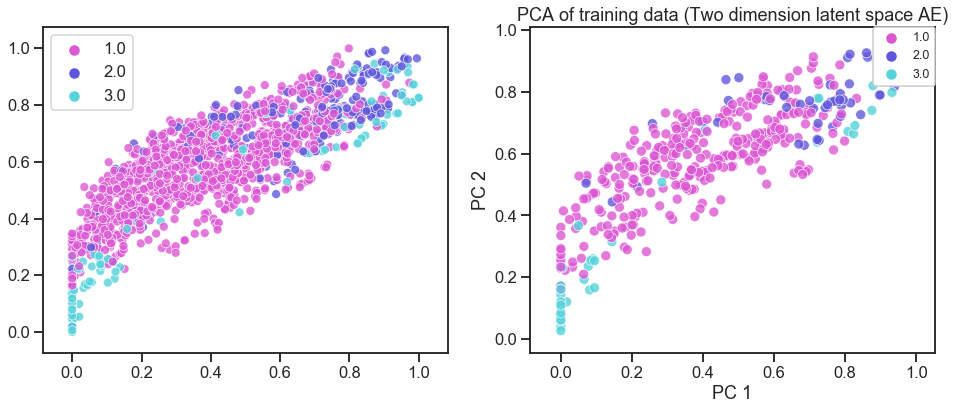

In [40]:
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
ax1 = plt.subplot(1,2,1)
sns.scatterplot(x=twodim_encoded_train_labeled[:,0], 
                y=twodim_encoded_train_labeled[:,1], 
                alpha = 0.8, 
                s= 80, legend='full', 
                hue=twodim_encoded_train_labeled[:,-1],
                palette=sns.color_palette("hls")[:2:-1])

ax1 = plt.subplot(1,2,2)
sns.scatterplot(x=twodim_encoded_test_labeled[:,0],
                y=twodim_encoded_test_labeled[:,1],
                alpha = 0.8, 
                s= 100, 
                legend='full',
                hue=twodim_encoded_test_labeled[:,-1], 
                palette=sns.color_palette("hls")[:2:-1])
ax1.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.,framealpha=1, frameon=True, fontsize="x-small")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (16,6) )
ax1.set_title("PCA of training data (Two dimension latent space AE)")

_________________
#### Latent Space Quality - Clustering
##### PCA vs Autoencoder

In [159]:
# Perform clustering on PCA reduced dimensionality dataset and AE latent space
# Dimension: 5
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
pca_cluster_labels = kmeans.fit_predict(X_pca)
pca_silhouette_avg = silhouette_score(X_pca, pca_cluster_labels)

kpca_cluster_labels = kmeans.fit_predict(X_kpca)
kpca_silhouette_avg = silhouette_score(X_kpca, kpca_cluster_labels)

ae_cluster_labels = kmeans.fit_predict(X_encoded)
ae_silhouette_avg = silhouette_score(X_encoded, ae_cluster_labels)

print(pca_cluster_labels)
print(f"PCA silhoutte score: {pca_silhouette_avg}")
print(kpca_cluster_labels)
print(f"KPCA silhoutte score: {kpca_silhouette_avg}")
print(ae_cluster_labels)
print(f"AE silhoutte score: {ae_silhouette_avg}")

[0 1 0 ... 1 1 2]
PCA silhoutte score: 0.2655426438826774
[1 1 0 ... 1 1 2]
KPCA silhoutte score: 0.2507086571432306
[0 1 0 ... 2 1 2]
AE silhoutte score: 0.3135799765586853


In [14]:
simple_encoded_train

,0,1,2,3,4
0,0.496918,0.0,0.0,0.0,0.0
1,0.211327,0.0,0.0,0.0,0.0
2,0.853227,0.0,0.0,0.0,0.0
3,0.412785,0.0,0.0,0.0,0.0
4,0.566617,0.0,0.0,0.0,0.0
...,...,...,...,...,...
1695,0.352064,0.0,0.0,0.0,0.0
1696,0.101482,0.0,0.0,0.0,0.0
1697,0.386404,0.0,0.0,0.0,0.0
1698,0.283241,0.0,0.0,0.0,0.0
